### Adding bells and whistles to the training loop

We enhance the training function for the pre-training and fine-tuning processes. We learn about <i>learning rate warmup</i>, <i>cosine decay</i> and <i>gradient clipping</i>.

In [1]:
# Initialise model trained in chapter 5
import torch
from Chapter04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50_257,
    "context_length": 256, # shortened from 1,024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [2]:
# Load the short story 
file_path = "../Datasets/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [3]:
# Data loaders
from Chapter04 import create_dataloader_v1

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

test_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

#### Learning rate warmup

This can stabilise the training of complex models like LLMs. The process involves gradually increasing the learning rate from a very low initial value (initial_lr) to a maximum value specified by the user (peak_lr). Starting with smaller weight updates decreases the risk of the model encountering large, destabilising updates during its training phase. The number of warmup steps if usually set between 0.1% and 20% of the total number of steps.

In [4]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

27


This prints 27, meaning that we have 20 warmup steps to increase the initial learning rate from 0.0001 to 0.01 in the first 27 training steps.

In [5]:
optimiser = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

# Training loop
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimiser.zero_grad()
        global_step += 1

        # updates the learning rate if still in warmup phase
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr

        for param_group in optimiser.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimiser.param_groups[0]["lr"])

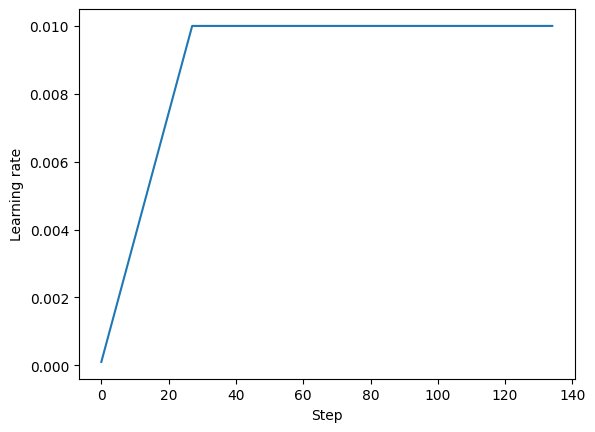

In [6]:
import matplotlib.pyplot as plt

plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.show()

Learning rate starts with a low value and increases for 20 steps until it reaches the maximum value after 20 steps. We can modify the learning rate further to improve the model training.

#### Cosine decay

This method modulates the learning rate throughout the training epochs, making it follow a cosine curve after the warmup stage. The learning rate is reduced to nearly 0, which aims to decelerate the pace at which the model updates its weights. This can help minimise the risk of overshooting the loss minima during the training process.

In [7]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimiser.zero_grad()
        global_step += 1

        if global_step < warmup_steps: # linear warmup
            lr = initial_lr + global_step * lr_increment
        else: # cosine annealing after warmup
            progress = ((global_step - warmup_steps) /
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress)
            )
        
        for param_group in optimiser.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimiser.param_groups[0]["lr"])

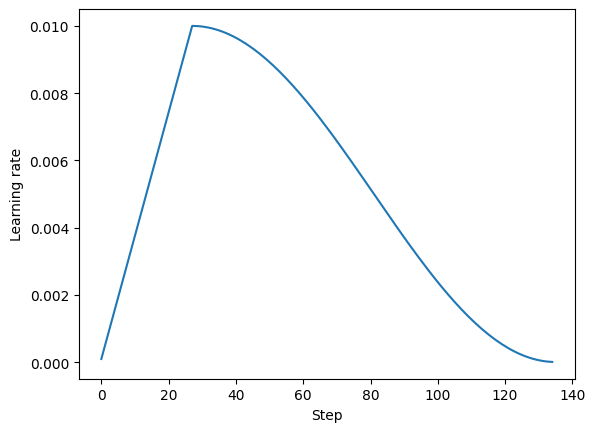

In [8]:
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.show()

#### Gradient clipping

This method involves setting a threshold above which gradients are downscaled to a predetermined maximum magnitude. This process ensures that the updates to the model's parameters during backpropagation stay within a manageable range. 

For example, applying max_norm = 1.0 ensures that the norm of the gradients does not surpass 1.0. Here, "norm" signifies that measure of the gradient vector's length, or magnitude, within the model's parameter space. E.g., we have a 2x2 gradient matrix with values 1,2,2,4. The L2 norm of these gradients is the square root of (1^2 + 2^2 + 2^2 + 4^2) = 5. This exceeds out max_norm of 1, so we scale down the gradients to ensure their norm equals exactly 1. This is achieved through a scaling factor (dividing each element within the gradient matrix by the L2 norm, 5). 

In [9]:
from Chapter05 import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

Upon calling .backward(), PyTorch calculates the loss gradients and stores them in a .grad attribute for each model weight (parameter tensor). To clarify the point, we identify the highest gradient value by scanning all the .grad attributes of the model's weight tensors.

In [10]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0461)


In [11]:
# Apply gradient clipping to see how this affects the largest gradient value
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0199)


The largest gradient value is substantially smaller than before after being clipped.

#### Modified training function

In [12]:
from Chapter05 import evaluate_model, generate_and_print_sample

def train_model(model, train_loader, val_loader, optimiser, device,
                n_epochs, eval_freq, eval_iter, start_context, tokeniser,
                warmup_steps, initial_lr=3e-05, min_lr=1e-06):
    
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    peak_lr = optimiser.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimiser.zero_grad()
            global_step += 1

            if global_step < warmup_steps: # linear warmup
                lr = initial_lr + global_step * lr_increment
            else: # cosine annealing after warmup
                progress = ((global_step - warmup_steps) /
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                    1 + math.cos(math.pi * progress)
                )

            for param_group in optimiser.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), max_norm=1.0
                )

            optimiser.step()
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Iter {global_step:06d}); "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(
            model, tokeniser, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs

In [13]:
import tiktoken

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
peak_lr = 5e-4
optimiser = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
tokeniser = tiktoken.get_encoding("gpt2")

n_epochs = 10
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, test_loader, optimiser, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Llamas love to eat",
    tokeniser=tokeniser, warmup_steps=warmup_steps,
    initial_lr=1e-5, min_lr=1e-5
)

NameError: name 'val_loader' is not defined